In [62]:
from ReadFile import Read
import numpy as np
from astropy import units as u
from CenterOfMass_Solution import CenterOfMass as COM
from GalaxyMass import ComponentMass
from matplotlib import pyplot as plt

In [144]:
class MassProfile:
# Class to define COM position and velocity properties of a given galaxy 
# and simulation snapshot

    def __init__(self, galaxy, snap):
        ''' 
        Class to calculate the 6-D phase-space position of a galaxy's center of mass using
        a specified particle type. 
            
        Inputs:
        -------
                galaxy (str): the name of the galaxy in question
                snap (int)  : the snapshot number of the file
        '''

        self.gname = galaxy
        #add a string of the filenumber to the value “000”
        ilbl = '000' + str(snap)
        # remove all but the last 3 digits
        ilbl = ilbl[-3:]
        self.filename= galaxy + '_'+ ilbl + '.txt'
            
        # read data in the given file using Read
        self.time, self.total, self.data = Read(self.filename)                                                                                             

        # store the mass, positions, velocities of only the particles of the given type
        # the following only gives the example of storing the mass
        self.m = self.data['m']*1e10
        # write your own code to complete this for positions and velocities
        self.x = self.data['x']*u.kpc
        self.y = self.data['y']*u.kpc
        self.z = self.data['z']*u.kpc

    def MassEnclosed(self, ptype, r):
        ''' 
        This function calculates the mass enclosed with a range of radii.

        Inputs:
        -------
                ptype (int): particle type reference number (1, 2, 3)
                r (range)  : numpy range of radii at which to evaluate

        Returns:
        --------
                m_total (range): mass enclosed within each radius in solMass
        '''

        if self.gname == 'M33' and ptype == 3:
            raise Exception('M33 does not have a bulge.')

        #create an array to store indexes of particles of desired Ptype                             
        index = np.where(self.data['type'] == ptype)
        COM_P = COM.COM_P(COM(self.filename, ptype), delta = 0.1)
        dx = self.x[index]-COM_P[0]
        dy = self.y[index]-COM_P[1]
        dz = self.z[index]-COM_P[2]
        distance = np.sqrt(dx**2 + dy**2 + dz**2)
        m_total = np.zeros(len(r))
        
        i = 0
        while i < len(m_total):
            index = np.where(distance <= r[i]*u.kpc)
            m = self.m[index]
            m_total[i] = np.sum(m)
            i += 1

        return m_total*u.solMass
    
    def TotalMassEnclosed(self, r):
        ''' 
        This function evaluates the enclosed mass of all particle types for a given galaxy.

        Inputs:
        -------
                r (range): numpy range of radii at which to evaluate

        Returns:
        -------
                m_total (range):  mass enclosed within each radius in solMass
        '''

        if self.gname == 'M33':
            ptypes = (1, 2)
        else:
            ptypes = (1,2,3)

        total_mass = np.sum(np.array([MassProfile.MassEnclosed(self, ptype, r) for ptype in ptypes]), axis = 0)

        return total_mass*u.solMass
    
    def HernquistMass(self, r, a, M_halo):
        '''
        This function evaluates the theoretical Henrnquist mass distribution at a given radius. 

        Inputs:
        -------
                r (float)     : radius at which to evaluate in kPc
                a (float)     : scale factor in kPc
                M_Halo (float): mass of the halo in solMass
        
        Returns:
        --------
                M_enclosed (solMass): mass enclosed according to the Hernquist model
        '''

        from astropy.constants import G
        G = G.to(u.kpc*u.km**2/u.s**2/u.Msun)
        M_enclosed = M_halo*r**2/((a + r)**2)
        return M_enclosed*u.solMass
    
    def CircularVelocity(self, ptype, r):
        '''
        This function evaluates the circular speed at a given radius depending only on one particle type.

        Inputs:
        -------
                ptype (int): particle type reference number (1, 2, 3)
                r (range)  : numpy range of radii at which to evaluate

        Returns:
        -------
                v (range): circular speed at the given radius in km/s
        '''
        if self.gname == 'M33' and ptype == 3:
            raise Exception('M33 does not have a bulge.')

        m = MassProfile.MassEnclosed(self, ptype, r)
        v = np.sqrt(G*m/r)
        return (np.round(v, 2))*u.km/u.s

    def CircularVelocityTotal(self, r):
        '''
        This function evaluates the circular speed at a given radius depending only on all particle types.

        Inputs:
        -------
                r (range)  : numpy range of radii at which to evaluate

        Returns:
        -------
                v (range): circular speed at the given radius in km/s
        '''

        m = MassProfile.TotalMassEnclosed(self, r)
        v = np.sqrt(G*m/r)
        return (np.round(v, 2))*u.km/u.s

    def HernquistVCirc(self, r, a, M_Halo):
        '''
        This function evaluates the circular speed at a given radius using the Hernquist mass profile.

        Inputs:
        -------
                r (float)     : radius at which to evaluate in kPc
                a (float)     : scale factor in kPc
                M_Halo (float): mass of the halo in solMass


        Returns:
        -------
                v (range): circular speed at the given radius in km/s
        '''

        m = MassProfile.HernquistMass(self, r, a, M_Halo)
        v = np.sqrt(G*m/r)
        return (np.round(v, 2))*u.km/u.s

In [126]:
MW = MassProfile('MW', 0)

r = np.arange(0.5, 30.25, 0.25)
m_DM_MW = MW.MassEnclosed(1, r)
m_H_MW = MW.MassEnclosed(2, r)
m_B_MW = MW.MassEnclosed(3, r)
m_total_MW = MW.TotalMassEnclosed(r)

[]

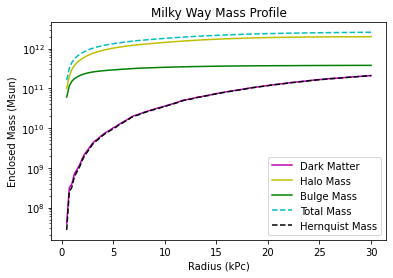

In [136]:
m_Hernquist_MW = MW.HernquistMass(r, 0.1, m_DM_MW)
plt.plot(r, m_DM_MW, 'm', label = "Dark Matter")
plt.plot(r, m_H_MW, 'y', label = "Halo Mass")
plt.plot(r, m_B_MW, 'g', label = "Bulge Mass")
plt.plot(r, m_total_MW, 'c--', label = "Total Mass")
plt.plot(r, m_Hernquist_MW, 'k--', label = 'Hernquist Mass')
plt.legend()
plt.title('Milky Way Mass Profile')
plt.xlabel('Radius (kPc)')
plt.ylabel('Enclosed Mass (Msun)')
plt.semilogy()

$a \approx 0.1$ kPc

In [163]:
v_DM_MW = MW.CircularVelocity(1, r)
v_H_MW = MW.CircularVelocity(2, r)
v_B_MW = MW.CircularVelocity(3, r)
v_total_MW = MW.CircularVelocityTotal(r)

[]

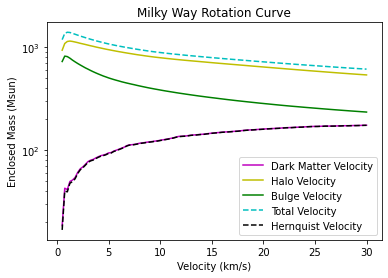

In [166]:
v_Hernquist_MW = MW.HernquistVCirc(r, 0.05, m_DM_MW)
plt.plot(r, v_DM_MW, 'm', label = "Dark Matter Velocity")
plt.plot(r, v_H_MW, 'y', label = "Halo Velocity")
plt.plot(r, v_B_MW, 'g', label = "Bulge Velocity")
plt.plot(r, v_total_MW, 'c--', label = "Total Velocity")
plt.plot(r, v_Hernquist_MW, 'k--', label = 'Hernquist Velocity')
plt.legend()
plt.title('Milky Way Rotation Curve')
plt.xlabel('Velocity (km/s)')
plt.ylabel('Enclosed Mass (Msun)')
plt.semilogy()

$a \approx 0.05$ kPc

In [139]:
M31 = MassProfile('M31', 0)

r = np.arange(0.5, 30.25, 0.25)
m_DM_M31 = M31.MassEnclosed(1, r)
m_H_M31 = M31.MassEnclosed(2, r)
m_B_M31 = M31.MassEnclosed(3, r)
m_total_M31 = M31.TotalMassEnclosed(r)

[]

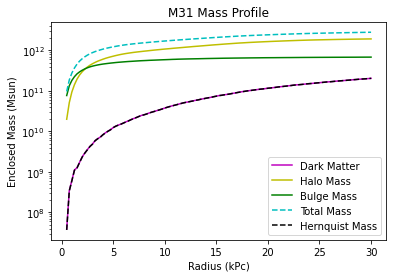

In [147]:
m_Hernquist_M33 = M31.HernquistMass(r, 0.01, m_DM_M31)
plt.plot(r, m_DM_M31, 'm', label = "Dark Matter")
plt.plot(r, m_H_M31, 'y', label = "Halo Mass")
plt.plot(r, m_B_M31, 'g', label = "Bulge Mass")
plt.plot(r, m_total_M31, 'c--', label = "Total Mass")
plt.plot(r, m_Hernquist_M33, 'k--', label = 'Hernquist Mass')
plt.legend()
plt.title('M31 Mass Profile')
plt.xlabel('Radius (kPc)')
plt.ylabel('Enclosed Mass (Msun)')
plt.semilogy()

$a \approx 0.1$ kPc

In [167]:
v_DM_M31 = M31.CircularVelocity(1, r)
v_H_M31 = M31.CircularVelocity(2, r)
v_B_M31 = M31.CircularVelocity(3, r)
v_total_M31 = M31.CircularVelocityTotal(r)

[]

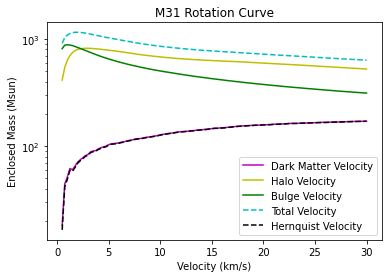

In [168]:
v_Hernquist_M31 = M31.HernquistVCirc(r, 0.05, m_DM_M31)
plt.plot(r, v_DM_M31, 'm', label = "Dark Matter Velocity")
plt.plot(r, v_H_M31, 'y', label = "Halo Velocity")
plt.plot(r, v_B_M31, 'g', label = "Bulge Velocity")
plt.plot(r, v_total_M31, 'c--', label = "Total Velocity")
plt.plot(r, v_Hernquist_M31, 'k--', label = 'Hernquist Velocity')
plt.legend()
plt.title('M31 Rotation Curve')
plt.xlabel('Velocity (km/s)')
plt.ylabel('Enclosed Mass (Msun)')
plt.semilogy()

$a \approx 0.05$ kPc

In [146]:
M33 = MassProfile('M33', 0)
r = np.arange(0.5, 30.25, 0.25)
m_DM_M33 = M33.MassEnclosed(1, r)
m_H_M33 = M33.MassEnclosed(2, r)
m_total_M33 = M33.TotalMassEnclosed(r)

[]

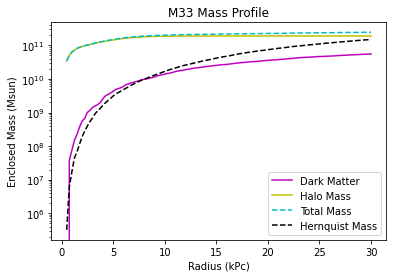

In [161]:
m_Hernquist_M33 = M33.HernquistMass(r, 5, m_DM_M31)
plt.plot(r, m_DM_M33, 'm', label = "Dark Matter")
plt.plot(r, m_H_M33, 'y', label = "Halo Mass")
plt.plot(r, m_total_M33, 'c--', label = "Total Mass")
plt.plot(r, m_Hernquist_M33, 'k--', label = 'Hernquist Mass')
plt.legend()
plt.title('M33 Mass Profile')
plt.xlabel('Radius (kPc)')
plt.ylabel('Enclosed Mass (Msun)')
plt.semilogy()

I actually can't get the Hernquist profile to fit properly, but a is on the order of 5.

In [170]:
v_DM_M33 = M33.CircularVelocity(1, r)
v_H_M33 = M33.CircularVelocity(2, r)
v_total_M33 = M33.CircularVelocityTotal(r)

[]

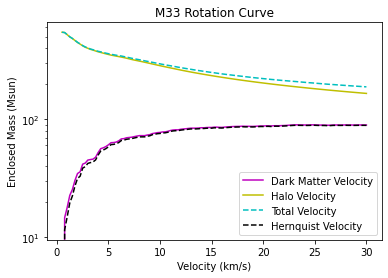

In [179]:
v_Hernquist_M33 = M33.HernquistVCirc(r, 0.2, m_DM_M33)
plt.plot(r, v_DM_M33, 'm', label = "Dark Matter Velocity")
plt.plot(r, v_H_M33, 'y', label = "Halo Velocity")
plt.plot(r, v_total_M33, 'c--', label = "Total Velocity")
plt.plot(r, v_Hernquist_M33, 'k--', label = 'Hernquist Velocity')
plt.legend()
plt.title('M33 Rotation Curve')
plt.xlabel('Velocity (km/s)')
plt.ylabel('Enclosed Mass (Msun)')
plt.semilogy()

From this, it looks like $a \approx 0.2$ kPc! This is a very different value than I found from the mass profile.